In [1]:
import time
import signal
import os
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display, Markdown # Import 'display' and 'Markdown'
import matplotlib.pyplot as plt
import sys

sys.path.insert(0, str('../../'))
sys.path.insert(0, str('../statistics_core'))

import SuguruSolvers
import SASolver
from stats_analysis import stats

## Funções

In [2]:
def timeout_handler(signum, frame):
    raise Exception('EndOfTime')

def get_pickle_data(file_path):
    with open(file_path, 'rb') as fp:
        data = pickle.load(fp)
    return data

def get_instances():
    # Load instances
    instances = list()
    for root, dirs, files in os.walk('../../instances/krazy_dad'):
        for filename in files:
            file_path = os.path.join(root, filename)
            instances.append(file_path)
    return instances

def parse_suguru_binary(path):
    if not os.path.isfile(path):
        raise Exception('Error: invalid file path')

    # Load from file
    with open(path, 'rb') as fp:
        rows = int.from_bytes(fp.read(2))
        cols = int.from_bytes(fp.read(2))
        arr = np.fromfile(fp, dtype=np.int16).reshape(3, rows, cols)
    return arr

def run_solver(solver):
    results = dict()
    instances = get_instances()
    for instance in instances:
        grid, _, regions = parse_suguru_binary(instance)

        # Get puzzle statistics
        tips = np.count_nonzero(grid != 0)
        size = grid.size
        region_count = np.max(regions.flatten())
        
        # 5 Minute timeout
        signal.signal(signal.SIGALRM, timeout_handler)
        signal.alarm(30)

        # Solving using the current solver
        solved = False
        timeout = True
        try:
            s = solver(grid, regions)
            start = time.perf_counter()
            solved = s.solve()
            end = time.perf_counter()
            elapsed = end - start
        except Exception as e:
            print('Skipping by timeout...')
            solved = False
            timeout = True

        signal.alarm(0)
        
        if solver not in results:
            results[solver] = {'solved':list(), 'elapsed':list(), 'puzzle':list(), 'tips':list(), 'size':list(), 'region_count':list(), 'timeout':False}
        
        if solved:
            results[solver]['solved'].append(1)
            results[solver]['elapsed'].append(elapsed)
        else:
            results[solver]['solved'].append(0)
            results[solver]['elapsed'].append(np.inf)

        results[solver]['tips'].append(tips)
        results[solver]['puzzle'].append(instance)
        results[solver]['size'].append(size)
        results[solver]['region_count'].append(region_count)
        results[solver]['timeout'] = timeout
        
        if len(results[solver]['solved']) % 100 == 0:
            print('[i] Tested: ', len(results[solver]['solved']))
            
    return results[solver]

## Simulated Annealing

In [3]:
# This might take very long!
#sa_stats = run_solver(SASolver.SASolver)
sa_stats = get_pickle_data('sav2.0k.pkl')

--- Starting Data Processing and Feature Engineering ---
Total Runs: 5598, Solved Runs: 1373
------------------------------
--- Key Performance Metrics ---
1. Overall Success Rate: 0.25 (1373/5598)
2. Avg Solving Time (Solved Only): 0.989 s
------------------------------
--- Robust Correlation Analysis ---
Point-Biserial Correlation (r) with SUCCESS RATE:
(* Positive 'r' means higher feature value is correlated with success.)
                      r_success        p_value
tip_density            0.135991   1.612927e-24
tips                  -0.332653  9.993668e-145
region_complexity     -0.346745  6.755655e-158
size                  -0.524740   0.000000e+00
region_count          -0.529808   0.000000e+00
log_difficulty_proxy  -0.565287   0.000000e+00

------------------------------
Pearson Correlation (r) with ELAPSED TIME (Solved Only):
(* Positive 'r' means higher feature value is correlated with longer time.)
                        r_time       p_value
size                  0.396316 

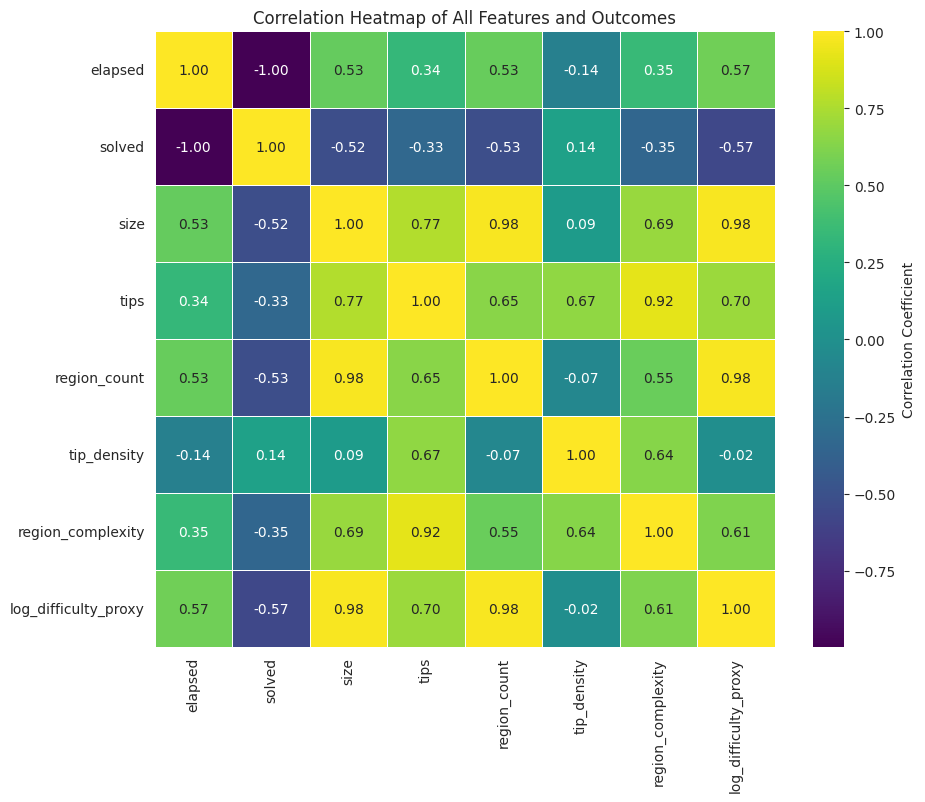


Generating Pair Plot...


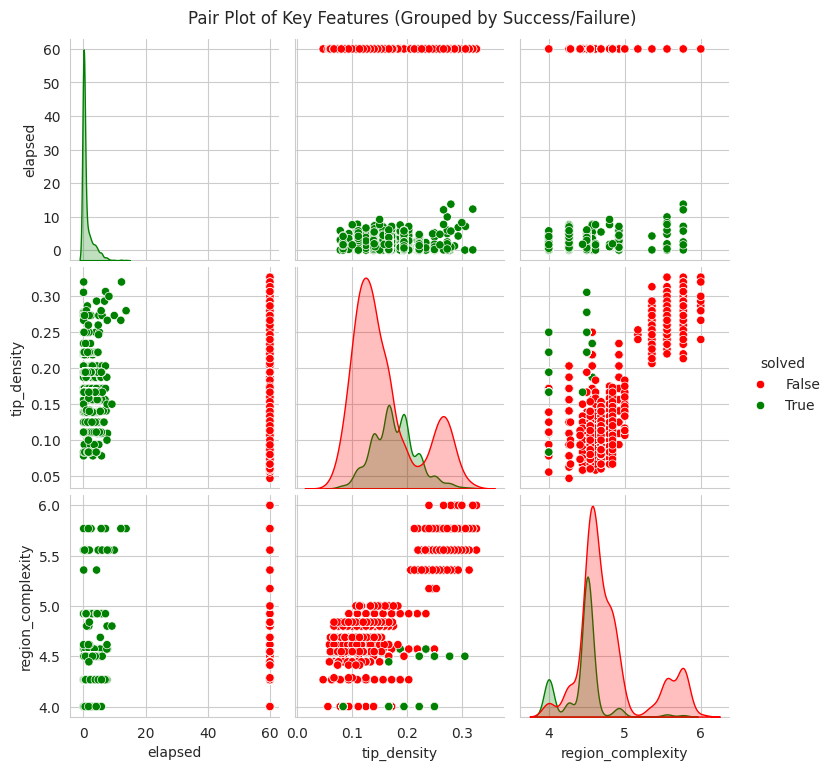

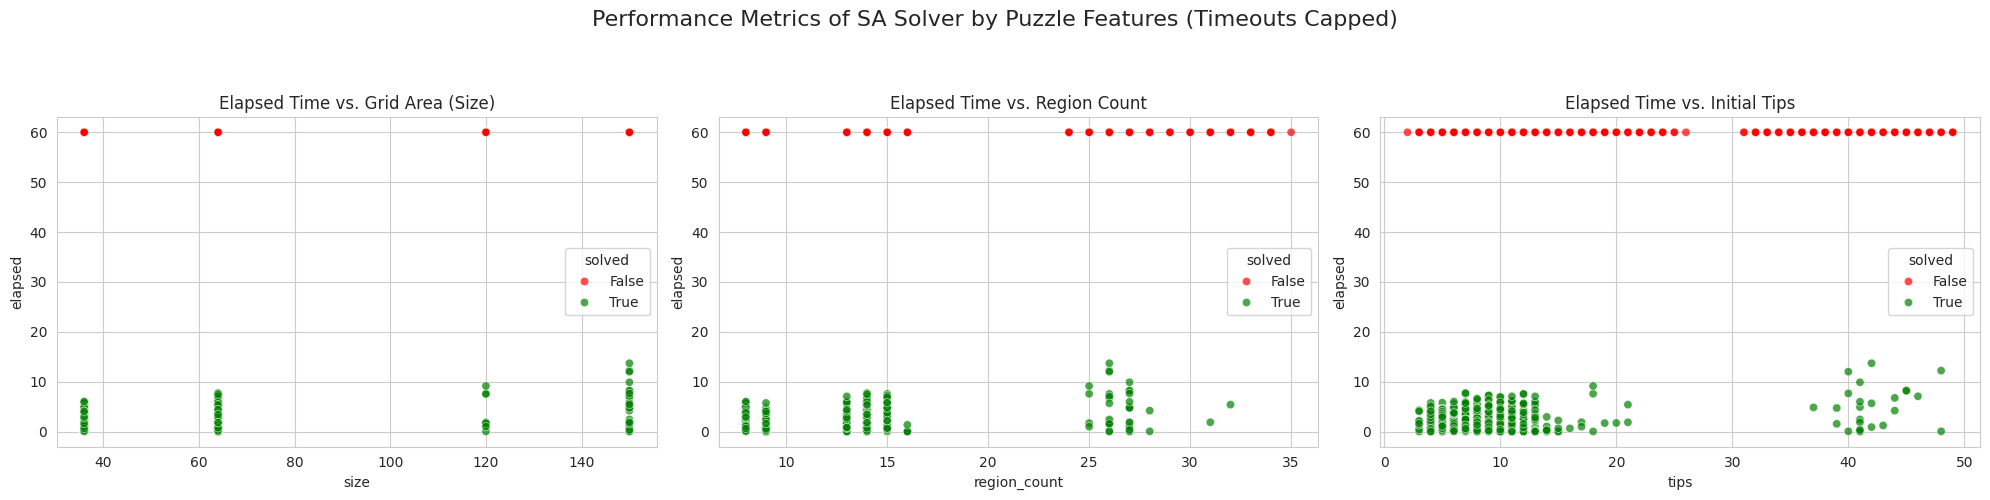

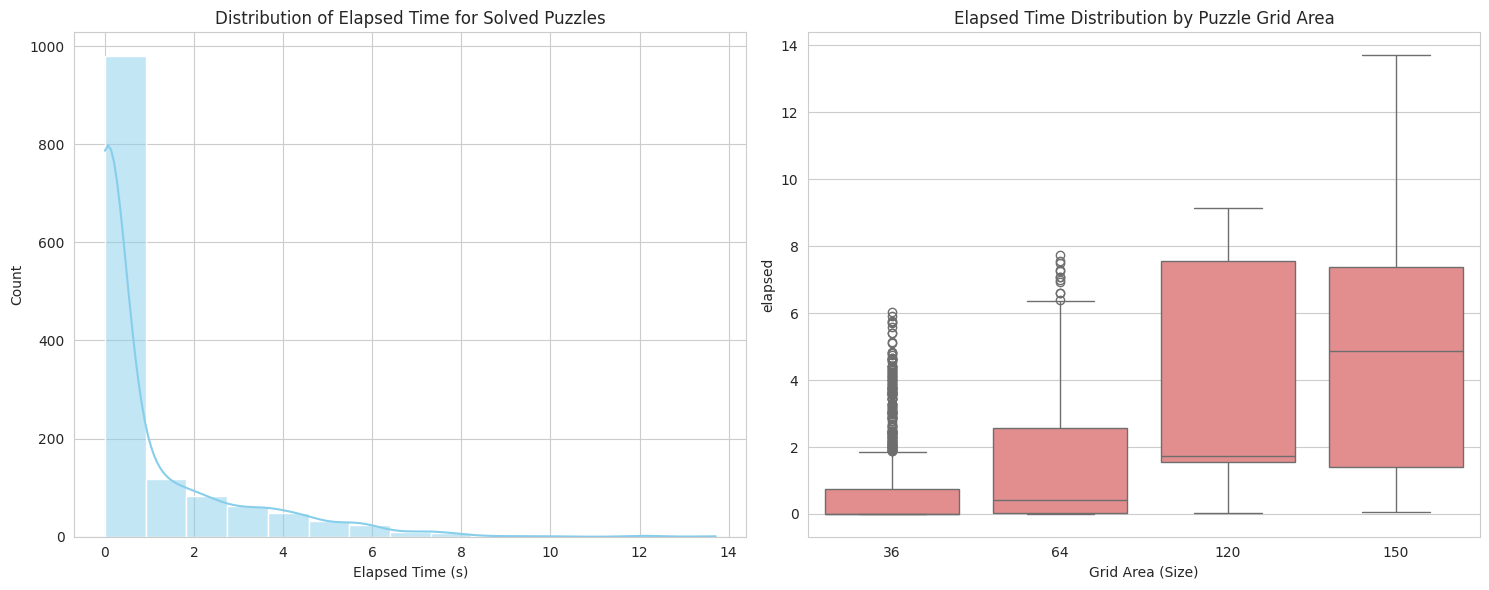

------------------------------
--- Analysis Complete ---


,solved,elapsed,puzzle,tips,size,region_count,timeout,tip_density,region_complexity,log_difficulty_proxy
0,True,0.011328,../../instances/krazy_dad/8x8_Suguru-89_1.data,12,64,14,True,0.187500,4.571429,6.797940
1,True,0.011046,../../instances/krazy_dad/8x8_Suguru-823_2.data,15,64,14,True,0.234375,4.571429,6.797940
2,True,0.012417,../../instances/krazy_dad/8x8_Suguru-871_3.data,11,64,14,True,0.171875,4.571429,6.797940
3,True,0.015335,../../instances/krazy_dad/8x8_Suguru-759_4.data,9,64,15,True,0.140625,4.266667,6.866933
4,True,0.016814,../../instances/krazy_dad/8x8_Suguru-322_5.data,10,64,15,True,0.156250,4.266667,6.866933
...,...,...,...,...,...,...,...,...,...,...
5593,False,60.000000,../../instances/krazy_dad/10x15_Suguru-532_796...,18,150,31,True,0.120000,4.838710,8.444622
5594,False,60.000000,../../instances/krazy_dad/10x15_Suguru-251_797...,14,150,31,True,0.093333,4.838710,8.444622
5595,False,60.000000,../../instances/krazy_dad/10x15_Suguru-59_798....,17,150,32,True,0.113333,4.687500,8.476371
5596,False,60.000000,../../instances/krazy_dad/10x15_Suguru-304_799...,10,150,31,True,0.066667,4.838710,8.444622


In [4]:
stats(sa_stats)